# nPRFs & GMs ?
loops over gradient_n and performs correlation with nPRF-R2 map while controlling for spatial autocorrelation (spin-permutation test) 
--> randomizes (rotates) over gradient map, nPRF stays

1. MagJudge task gradients with nPRFs (fsaverage5)
2. Margulies resting state gradients with nPRFs (fsLR)


### Add: Data prep
* surface transformations (fsav to fsav5)
* fsavTofsLR (nPRF param)

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
import seaborn as sns

bids_folder = '/mnt_03/ds-dnumrisk' 
key = 'encoding_model.denoise'
nPRF_dir = op.join(bids_folder,'derivatives',key,'averages')

group = 'all'
par = 'r2'


## 1.  MagJudge task gradients, fsaverage space

In [ ]:
space = 'fsaverage5'
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')
nprf_r2_L = nib.load(nPRF_fn).agg_data()
nPRF_fn =  op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')
nprf_r2_R = nib.load(nPRF_fn).agg_data()

nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))
#np.shape(nprf_r2_R)

(10242,)

In [12]:
from  nilearn.datasets import fetch_surf_fsaverage

fsaverage = fetch_surf_fsaverage(space) 

surf_lh, surf_rh = fsaverage.pial_left , fsaverage.pial_right # load_conte69() = surf : tuple of BSPolyData or BSPolyData
sphere_lh, sphere_rh = fsaverage.sphere_left , fsaverage.sphere_right

#pati = '/mnt_03/ds-dnumrisk/derivatives/freesurfer/fsaverage5/surf/' ; import nilearn.plotting as nplt


In [13]:
from brainspace.mesh.mesh_io import read_surface

surf_lh = read_surface(surf_lh)
surf_rh = read_surface(surf_rh)

sphere_lh = read_surface(sphere_lh)
sphere_rh = read_surface(sphere_rh)


In [14]:
from brainspace.null_models import SpinPermutations

n_rand = 1000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

#nPRF_rotated = np.hstack(sp.randomize(nprf_r2_L, nprf_r2_R))


SpinPermutations(n_rep=1000, random_state=0)

In [ ]:
# this makes the kernel crash!
#from brainspace.plotting import plot_hemispheres

plot_hemispheres(surf_lh, surf_rh, array_name=nPRF_rotated[:3], size=(1200, 600),
                 cmap='viridis', nan_color=(0.5, 0.5, 0.5, 1), color_bar=True,
                 zoom=1.55, label_text=['Rot0', 'Rot1', 'Rot2'])

In [ ]:
# 
sub='All'
n_comp = 10
grad_folder = 'derivatives/gradients'
fn = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_gradients_N-{n_comp}.npy')
grad = np.load(fn)

feats = {}
rotated = {}
for n_grad in range(5,10):
    gm = np.split(grad[n_grad],2) 
    gradients = np.concatenate((gm[0], gm[1]))
    gm_rotated = np.hstack(sp.randomize(gm[0], gm[1]))

    feats[f'grad{n_grad+1}'] = gradients
    rotated[f'grad{n_grad+1}'] = gm_rotated


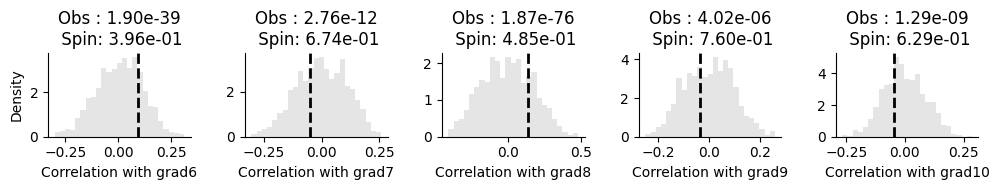

In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, len(feats), figsize=(len(feats)*2, 2))

r_spin = np.empty(n_rand)
mask = ~np.isnan(gradients)

for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = spearmanr(feat[mask], nprf_r2[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = spearmanr(perm[mask_rot], nprf_r2[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    axs[k].set_title(f'Obs : {pv_obs:.2e}\n Spin: {pv_spin:.2e}')
    if k == 0:
        axs[k].set_ylabel('Density')
    #print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

fig.tight_layout()
sns.despine()
plt.show()



## 2. Margulies16 resting state Gradients

In [20]:
# load nPRF-r2 in fsLR space
space = 'fsLR_den-32k'

nPRF_L = nib.load(op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')).agg_data()
nPRF_R = nib.load(op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')).agg_data()

nPRF = np.concatenate((nPRF_L, nPRF_R))

In [21]:
from neuromaps.datasets import fetch_atlas

fsLR = fetch_atlas('fsLR', '32k')
fsLR['sphere'][0]

from brainspace.mesh.mesh_io import read_surface

surf_lh = read_surface(str(fsLR['midthickness'][0]))
surf_rh = read_surface(str(fsLR['midthickness'][1]))

sphere_lh = read_surface(str(fsLR['sphere'][0]))
sphere_rh = read_surface(str(fsLR['sphere'][1]))

In [22]:
from brainspace.null_models import SpinPermutations

n_rand = 1000
sp = SpinPermutations(n_rep=n_rand, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

SpinPermutations(n_rep=1000, random_state=0)

In [ ]:
from neuromaps.datasets import fetch_annotation

margulies2016 = fetch_annotation(source='margulies2016')

feats = {}
rotated = {}
for n_grad in range(5):
    margulies_grad_L= nib.load(margulies2016['margulies2016',f'fcgradient0{n_grad+1}','fsLR','32k'][0]).agg_data()
    margulies_grad_R= nib.load(margulies2016['margulies2016',f'fcgradient0{n_grad+1}','fsLR','32k'][1]).agg_data()

    gradients = np.concatenate((margulies_grad_L,margulies_grad_R))
    gm_rotated = np.hstack(sp.randomize(margulies_grad_L, margulies_grad_R))

    feats[f'grad{n_grad+1}'] = gradients
    rotated[f'grad{n_grad+1}'] = gm_rotated

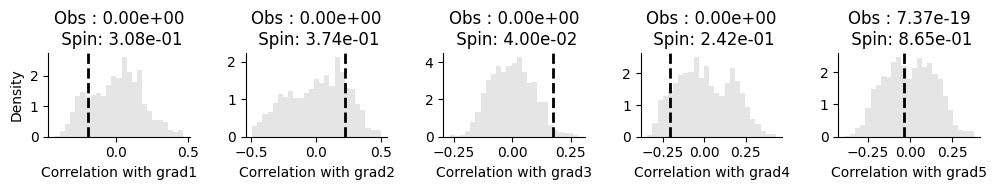

In [25]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, axs = plt.subplots(1, len(feats), figsize=(len(feats)*2, 2))

mask = ~np.isnan(gradients)
r_spin = np.empty(n_rand)

for k, (fn, feat) in enumerate(feats.items()):
    r_obs, pv_obs = spearmanr(feat[mask], nPRF[mask])

    # Compute perm pval
    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove midline
        r_spin[i] = spearmanr(perm[mask_rot], nPRF[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_spin, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    axs[k].set_title(f'Obs : {pv_obs:.2e}\n Spin: {pv_spin:.2e}')
    if k == 0:
        axs[k].set_ylabel('Density')
    #print(f'{fn.capitalize()}:\n Obs : {pv_obs:.5e}\n Spin: {pv_spin:.5e}\n')

fig.tight_layout()
sns.despine()
plt.show()

# addtional stuff

In [ ]:
from nipype.interfaces.freesurfer import SurfaceTransform # needs the fsaverage & fsaverage5 in ..derivatives/freesurfer folder!
source_space = 'fsaverage'
target_space = 'fsaverage5'

for hemi in ['L', 'R']:
    sxfm = SurfaceTransform(subjects_dir=op.join(bids_folder,'derivatives','freesurfer'))

    sxfm.inputs.source_file = op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{source_space}_hemi-{hemi}.func.gii')
    sxfm.inputs.out_file = op.join(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{target_space}_hemi-{hemi}.func.gii')
    sxfm.inputs.source_subject = source_space 
    sxfm.inputs.target_subject = target_space 
    sxfm.inputs.hemi = 'lh' if hemi == 'L' else 'rh'

    r = sxfm.run()

In [ ]:
# transform to fsLR to compare to MarguliesFCgradients

from utils import fsavTofsLR
space = 'fsaverage5'

for hemi in ['L','R']:
        fsavTofsLR(nPRF_dir, f'group-{group}_desc-{par}.optim.nilearn_space-{space}_hemi-{hemi}.func.gii',hemi)